# <center>PUBG Finih Placement Prediction</center>
<center> Gallet Benjamin </center>
<center> Kitschminyof Stephan </center>

<center><a href="https://github.com/KitschminyofStephan/pubg_finish_placement_prediction">Projet sur Github</a></center>

<img src="Datas/Pictures/pubg_background.jpg"
     alt="PUBG background" 
     style="float: left; margin: 0;" />

**PlayerUnknown's Battlegrounds (PUBG)** est un jeu vidéo multijoueur en ligne de type battle royal. Le jeu se déroule sous forme de parties en équipe ou en solo dont le but est d'éliminer les autres joueurs pour être la dernière équipe en vie.

Le but de cette compétition est de prédire **le pourcentage de chance qu'un joueur à de gagner une partie** en fonction des données qui sont mises à disposition. Ces données sont assez variées, elle comprennent par exemple le nombre de dégats infligés ou la distance parcourue par le joueur au cours d'une partie.

Pour plus d'information, vous pouvez retrouver le sujet de la compétition kaggle <a href="https://www.kaggle.com/c/pubg-finish-placement-prediction">ici</a> 


In [1]:
# Import lib
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import numpy

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prepro

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingClassifier

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Import data
def importData():
    # Import from file
    train = pd.read_csv("Datas/train_V2.csv")
    test = pd.read_csv("Datas/test_V2.csv")

    # Split train to have validate
    testSize = max(test.count())    
    train, validate = train_test_split(train, test_size=testSize)
    
    return train, validate, test

train, validate, test = importData()

print('Setup complete !')

Setup complete !


## Analyse des données

Expliquation des colonnes (données dans le sujet de la compétition kaggle)
* <strong>DBNOs</strong> - Number of enemy players knocked.
* <strong>assists</strong> - Number of enemy players this player damaged that were killed by teammates.
* <strong>boosts</strong> - Number of boost items used.
* <strong>damageDealt</strong> - Total damage dealt. Note: Self inflicted damage is subtracted.
* <strong>headshotKills</strong> - Number of enemy players killed with headshots.
* <strong>heals</strong> - Number of healing items used.
* <strong>Id</strong> - Player’s Id
* <strong>killPlace</strong> - Ranking in match of number of enemy players killed.
* <strong>killPoints</strong> - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a * value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* <strong>killStreaks</strong> - Max number of enemy players killed in a short amount of time.
* <strong>kills</strong> - Number of enemy players killed.
* <strong>longestKill</strong> - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* <strong>matchDuration</strong> - Duration of match in seconds.
* <strong>matchId</strong> - ID to identify match. There are no matches that are in both the training and testing set.
* <strong>matchType</strong> - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* <strong>rankPoints</strong> - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* <strong>revives</strong> - Number of times this player revived teammates.
* <strong>rideDistance</strong> - Total distance traveled in vehicles measured in meters.
* <strong>roadKills</strong> - Number of kills while in a vehicle.
* <strong>swimDistance</strong> - Total distance traveled by swimming measured in meters.
* <strong>teamKills</strong> - Number of times this player killed a teammate.
* <strong>vehicleDestroys</strong> - Number of vehicles destroyed.
* <strong>walkDistance</strong> - Total distance traveled on foot measured in meters.
* <strong>weaponsAcquired</strong> - Number of weapons picked up.
* <strong>winPoints</strong> - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* <strong>groupId</strong> - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* <strong>numGroups</strong> - Number of groups we have data for in the match.
* <strong>maxPlace</strong> - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* <strong>winPlacePerc</strong> - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2512792 entries, 3123182 to 4325951
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoi

In [3]:
# Print the first 5 rows of the data
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3123182,17c6863cfa77bb,0f31de4fe39290,656a87bf1aa737,0,1,154.40,1,0,0,57,...,0,0.0,0,0.0,0,0,1413.0,6,0,0.5625
1542433,a72ae5c2be3fa0,3658e7b86085b9,c445617e12a5af,0,0,100.00,1,0,0,59,...,0,0.0,0,0.0,0,0,157.9,2,0,0.3846
4188013,cb3a0cb0785905,123922fa33ca08,fa54774cab09a8,0,1,226.20,0,0,0,36,...,0,0.0,0,0.0,0,0,133.0,3,0,0.3684
3144807,1dfa9cec998945,1180f87fa79f35,971bfd4f083ece,0,1,200.00,2,0,1,37,...,0,0.0,0,0.0,0,0,182.7,3,0,0.1702
2286466,ba969eb8654854,2ac09e95077691,7c96880894e712,0,0,70.73,0,0,0,87,...,0,0.0,0,0.0,0,0,15.9,1,0,0.1481


In [4]:
train.corr()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1.000000,0.307640,0.407793,0.300497,0.199127,0.228203,-0.290132,0.039553,0.320790,0.243772,...,0.198020,0.111486,0.011289,0.023042,0.006721,0.057397,0.289273,0.244506,0.024512,0.298769
boosts,0.307640,1.000000,0.521955,0.359764,0.334210,0.535534,-0.554633,0.008971,0.501863,0.405447,...,0.253529,0.328865,0.035598,0.108151,0.013392,0.087696,0.639537,0.406846,-0.007119,0.634037
damageDealt,0.407793,0.521955,1.000000,0.735639,0.613021,0.342625,-0.677616,0.050215,0.888814,0.703800,...,0.257811,0.141365,0.053043,0.036484,0.015876,0.080438,0.397547,0.354394,0.017928,0.440113
DBNOs,0.300497,0.359764,0.735639,1.000000,0.469586,0.265631,-0.556095,0.043384,0.707855,0.647594,...,0.302663,0.102676,0.035660,0.017060,0.070298,0.059126,0.284930,0.217936,0.011662,0.280203
headshotKills,0.199127,0.334210,0.613021,0.469586,1.000000,0.199753,-0.469432,0.024283,0.674144,0.511892,...,0.150874,0.076350,0.014129,0.028821,0.009677,0.038587,0.250430,0.218310,0.005184,0.277675
heals,0.228203,0.535534,0.342625,0.265631,0.199753,1.000000,-0.385797,-0.001709,0.311157,0.269963,...,0.236803,0.296935,0.025464,0.080719,0.036308,0.064007,0.430135,0.308659,-0.010129,0.427890
killPlace,-0.290132,-0.554633,-0.677616,-0.556095,-0.469432,-0.385797,1.000000,-0.023949,-0.730350,-0.810428,...,-0.269979,-0.236018,-0.057306,-0.089733,-0.038650,-0.073437,-0.589724,-0.490024,-0.002959,-0.718635
killPoints,0.039553,0.008971,0.050215,0.043384,0.024283,-0.001709,-0.023949,1.000000,0.036554,0.037218,...,0.012494,-0.028589,-0.003854,-0.004494,-0.039680,-0.009312,0.005977,-0.003029,0.983420,0.014081
kills,0.320790,0.501863,0.888814,0.707855,0.674144,0.311157,-0.730350,0.036554,1.000000,0.802265,...,0.254203,0.114946,0.063592,0.038969,0.017852,0.079165,0.374264,0.337953,0.007163,0.419531
killStreaks,0.243772,0.405447,0.703800,0.647594,0.511892,0.269963,-0.810428,0.037218,0.802265,1.000000,...,0.242181,0.098275,0.065883,0.034651,0.028095,0.063828,0.327246,0.275382,0.008512,0.377103


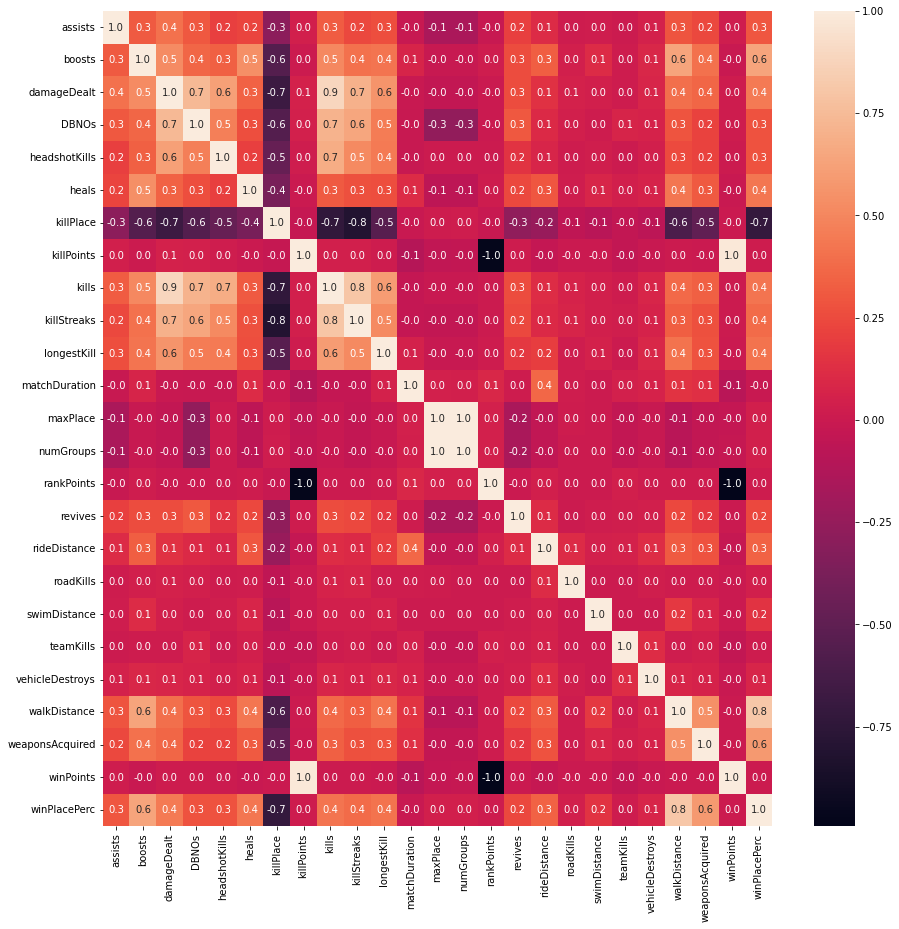

In [5]:
plt.subplots(figsize=(15,15))
sns.heatmap(train.corr(), fmt='.1f', annot=True)
plt.show()

Avec une première analyse sur la corrélation des données on peut voir que certaines colonnes n'ont pas d'impact sur la target (winPlacePerc).

Ainsi pour notre modèle de prédiction, on ne prendra pas en compte les colonnes suivantes : "rankPoint", "killPoint" et "winPoint".

On peut en revanche retenir la liste suivante qui contient les colonnes qui nous semblent avoir une influence sur la position du joueur en fin de partie : 
* boosts
* damageDealt
* heals
* killPlace
* longestKill
* revives
* rideDistance
* swimDistance
* walkDistance
* weaponAcquired

In [6]:
# On retire les Colonnes avec faible corrélation (expliqué plus haut)
train = train.drop(columns=["rankPoints", "killPoints", "winPoints"])
test = test.drop(columns=["rankPoints", "killPoints", "winPoints"])
validate = validate.drop(columns=["rankPoints", "killPoints", "winPoints"])

## Normalization des données
Ici on retire les lignes où il manque des données et on change les colonnes qui sont de type *object* en type *int*. Cela permet de ne pas rencontrer de problèmes dans la suite lors des prédictions avec des colonnes qui n'ont pas de valeurs ou qui ont des valeurs non numériques.

In [7]:
def normalization(data):
    le = prepro.LabelEncoder()
    le.fit(data["matchType"])
    data["matchType"] = le.transform(data["matchType"])
    le.fit(data["Id"])
    data["Id"] = le.transform(data["Id"])
    le.fit(data["groupId"])
    data["groupId"] = le.transform(data["groupId"])
    le.fit(data["matchId"])
    data["matchId"] = le.transform(data["matchId"])
    
    data = data.dropna()
    return data

train = normalization(train)
validate = normalization(validate)
test = normalization(test)

In [8]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
3123182,233311,91102,18974,0,1,154.40,1,0,0,57,...,46,0,0.0,0,0.0,0,0,1413.0,6,0.5625
1542433,1639989,325281,36704,0,0,100.00,1,0,0,59,...,26,0,0.0,0,0.0,0,0,157.9,2,0.3846
4188013,1994798,109093,46842,0,1,226.20,0,0,0,36,...,91,0,0.0,0,0.0,0,0,133.0,3,0.3684
3144807,293955,104797,28253,0,1,200.00,2,0,1,37,...,47,0,0.0,0,0.0,0,0,182.7,3,0.1702
2286466,1831135,255640,23317,0,0,70.73,0,0,0,87,...,28,0,0.0,0,0.0,0,0,15.9,1,0.1481


# Quelques graphiques pour analyser nos données
## killPlace

<AxesSubplot:title={'center':'PUBG killPlace impact on winPlacePerc'}, xlabel='killPlace', ylabel='winPlacePerc'>

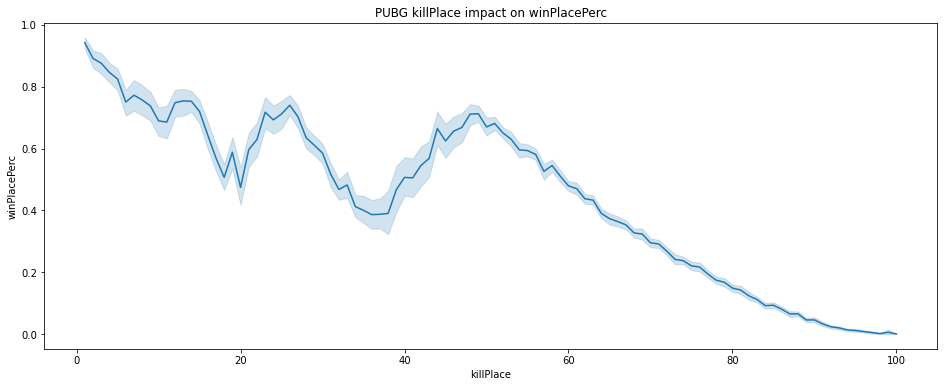

In [9]:
# Relation between winPlacePerc and killPlace
# Attention la valeur de killPlace est un classement donc la valeur 1 est la meilleure place et 100 la pire
data_to_plot = train.head(10000)

plt.figure(figsize=(16,6))
plt.title('PUBG killPlace impact on winPlacePerc')
sns.lineplot(x=data_to_plot['killPlace'], y=data_to_plot['winPlacePerc'])

Ce graphique nous montre qu'il y a une forte relation entre **killPlace** (le classement par rapport au nombre d'ennemie tué) et la chance de gagner une partie. En effet, si un joueur a une **killPlace** à *1*, c'est qu'il est le joueur qui a fait le plus de kill dans la partie, et voit sont **winPlacePerc** proche des 100%.

Donc en règle générale, un joueur faisant beaucoup de kills va avoir plus de chance de gagner que les joueurs faisant peu de kills.

On vient de voir que **killPlace** était une variable importante pour notre modèle de prédictions.
Mais en regardant nos données, on peut voir que beaucoup de colonnes sont en liens avec les dégats et les éliminations. 
On recherche maintenant les variables qui sont en lien avec **killPlace**. Une fois trouvée, elles pourront être retirée du jeu de données car elle seront réprésentées par **killPlace**.

<AxesSubplot:title={'center':'data in link with KillPlace column'}, xlabel='kills', ylabel='killPlace'>

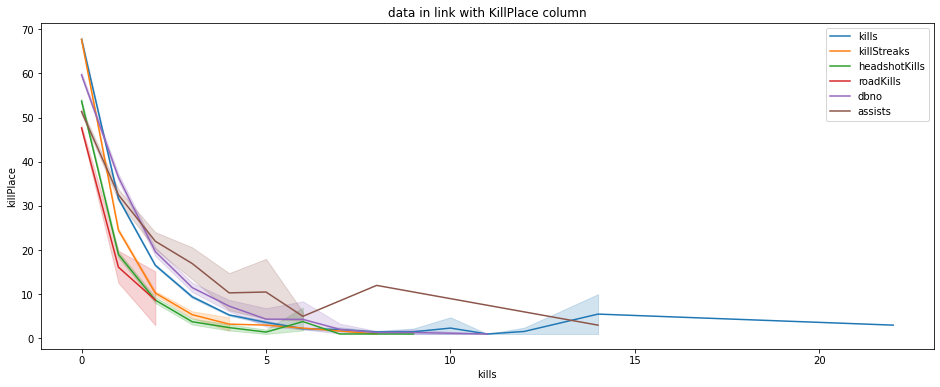

In [10]:
plt.figure(figsize=(16,6))

plt.title("data in link with KillPlace column")

sns.lineplot(x=data_to_plot['kills'] , y=data_to_plot['killPlace'], label="kills")
sns.lineplot(x=data_to_plot['killStreaks'] , y=data_to_plot['killPlace'], label="killStreaks")
sns.lineplot(x=data_to_plot['headshotKills'] , y=data_to_plot['killPlace'], label="headshotKills")
sns.lineplot(x=data_to_plot['roadKills'] , y=data_to_plot['killPlace'], label="roadKills")
sns.lineplot(x=data_to_plot['DBNOs'] , y=data_to_plot['killPlace'], label="dbno")
sns.lineplot(x=data_to_plot['assists'] , y=data_to_plot['killPlace'], label="assists")

# damageDealt ? correspond un peu mais au début pas vraiment

In [11]:
# Drop columns link to killPlace
columnsLinkToKillPlace = ["kills", "killStreaks", "headshotKills", "roadKills", "DBNOs", "assists"]

train = train.drop(columns=columnsLinkToKillPlace).copy()
validate = validate.drop(columns=columnsLinkToKillPlace).copy()
test = test.drop(columns=columnsLinkToKillPlace).copy()

## Distance
Dans les données, on retrouve 3 colonnes qui servent à mesurer des distances :
* rideDistance
* swimDistance
* walkDistance 

On a regroupé ces colonnes en une seule en faisant la somme de ces colonnes car l'information importante est la distance globale parcourue par les joueurs qui gagnent.

In [12]:
# Regroup distance
train["distance"] = train["rideDistance"] + train["swimDistance"] + train["walkDistance"]
train = train.drop(columns=["rideDistance", "swimDistance", "walkDistance"])

validate["distance"] = validate["rideDistance"] + validate["swimDistance"] + validate["walkDistance"]
validate = validate.drop(columns=["rideDistance", "swimDistance", "walkDistance"])

test["distance"] = test["rideDistance"] + test["swimDistance"] + test["walkDistance"]
test = test.drop(columns=["rideDistance", "swimDistance", "walkDistance"])

In [13]:
# Exploration basique des données
train.describe()

,Id,groupId,matchId,boosts,damageDealt,heals,killPlace,longestKill,matchDuration,matchType,maxPlace,numGroups,revives,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,distance
count,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06,2.512791e+06
mean,1.256395e+06,7.647957e+05,2.397380e+04,1.105574e+00,1.306574e+02,1.368843e+00,4.759626e+01,2.298040e+01,1.579382e+03,1.083101e+01,4.450023e+01,4.300323e+01,1.647156e-01,2.390768e-02,7.893613e-03,3.660362e+00,4.726326e-01,1.763301e+03
std,7.253805e+05,4.414677e+05,1.384508e+04,1.714178e+00,1.706626e+02,2.677515e+00,2.745484e+01,5.091349e+01,2.587840e+02,5.325642e+00,2.382627e+01,2.328807e+01,4.726730e-01,1.674088e-01,9.245776e-02,2.456683e+00,3.072819e-01,2.181648e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.330000e+02,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.281975e+05,3.824710e+05,1.198300e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,1.367000e+03,3.000000e+00,2.800000e+01,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e-01,1.581000e+02
50%,1.256395e+06,7.653440e+05,2.398300e+04,0.000000e+00,8.424000e+01,0.000000e+00,4.700000e+01,0.000000e+00,1.438000e+03,1.400000e+01,3.000000e+01,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,4.583000e-01,7.875000e+02
75%,1.884592e+06,1.147272e+06,3.595700e+04,2.000000e+00,1.860000e+02,2.000000e+00,7.100000e+01,2.133000e+01,1.851000e+03,1.500000e+01,4.900000e+01,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,7.407000e-01,2.725100e+03
max,2.512791e+06,1.529102e+06,4.796300e+04,2.400000e+01,6.616000e+03,8.000000e+01,1.000000e+02,1.075000e+03,2.237000e+03,1.500000e+01,1.000000e+02,1.000000e+02,3.900000e+01,7.000000e+00,5.000000e+00,1.670000e+02,1.000000e+00,4.127010e+04


# Les soins
On peut constater qu'il y a aussi une relation entre les colonnes **heals** et **winPlacePerc**

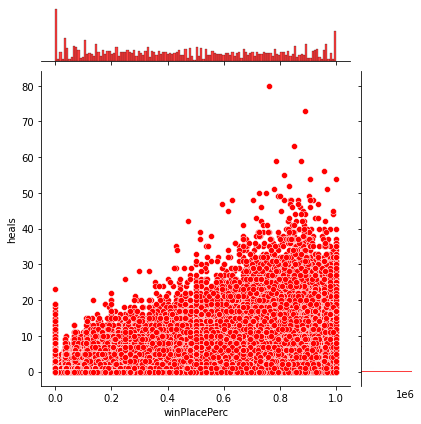

In [14]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, color="red")
plt.show()

# Les améliorations des armes (boosts)
Idem que pour les soins on peut valider l'importance de la colonne boosts pour notre modèle de prédictions

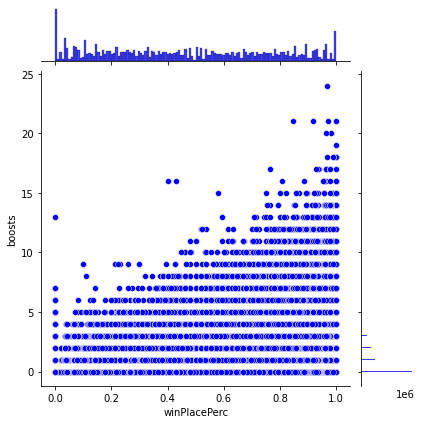

In [15]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, color="blue")
plt.show()

# Préparation des données

In [16]:
train_y = train.winPlacePerc
train_X = train.drop(columns=["winPlacePerc"])

validate_X = validate.drop(columns=["winPlacePerc"])
validate_y = validate["winPlacePerc"]

# Decision tree Model

In [17]:
# Define model
dtr_model = DecisionTreeRegressor(random_state=1)

# Fit model
dtr_model.fit(train_X, train_y)

# Predict
dtr_predict_validate = dtr_model.predict(validate_X)

dtr_predict_validate

array([0.9286, 0.5   , 0.    , ..., 0.4074, 0.7083, 0.6598])

### Evaluation de notre modèle

Une erreur représente la différence entre la valeur voulue et la prédiction.

**MAE** (Mean Absolute Error) est la moyenne des valeurs absoluts des erreurs.

In [18]:
# MAE
mean_absolute_error(validate_y, dtr_predict_validate)

0.08781120638577504

Pour améliorer cette valeur, on peut jouer sur les paramètres de DecissionTreeRegressor comme max_leaf_nodes et max_depth.

In [19]:
def get_mae_with_leaf_nodes(train_X, train_y, validate_X, validate_y, max_leaf_nodes):
    # Define
    dtr_model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=1)
    
    # Fit
    dtr_model.fit(train_X, train_y)
    
    # Predict
    validate_predict = dtr_model.predict(validate_X)
    
    # MAE
    mae = mean_absolute_error(validate_y, validate_predict)
    return mae

for max_leaf_nodes in [5, 50, 500, 5000, 10000, 20000, 40000, 100000]:
    mae = get_mae_with_leaf_nodes(train_X, train_y, validate_X, validate_y, max_leaf_nodes)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %f" %(max_leaf_nodes, mae))

Max leaf nodes: 5  		 Mean Absolute Error:  0.116153
Max leaf nodes: 50  		 Mean Absolute Error:  0.084248
Max leaf nodes: 500  		 Mean Absolute Error:  0.071452
Max leaf nodes: 5000  		 Mean Absolute Error:  0.066285
Max leaf nodes: 10000  		 Mean Absolute Error:  0.066173
Max leaf nodes: 20000  		 Mean Absolute Error:  0.066751
Max leaf nodes: 40000  		 Mean Absolute Error:  0.068182
Max leaf nodes: 100000  		 Mean Absolute Error:  0.071910


Pour réduire notre MAE, il faut choisir le max_leaf_nodes qui donne le mae le plus petit. Ainsi on réduit le Underfitting ou le Overfitting.

Max_leaf_nodes = 10000

In [20]:
dtr_model.score(validate_X, validate_y)

0.8243556424979233

In [21]:
# Define model
dtr_model_2 = DecisionTreeRegressor(max_leaf_nodes=10000, random_state=1)

# Fit model
dtr_model_2.fit(train_X, train_y)

# Predict
dtr_predict_validate_2 = dtr_model.predict(validate_X)

dtr_predict_validate_2

array([0.9286, 0.5   , 0.    , ..., 0.4074, 0.7083, 0.6598])

On peut voir qu'avec ce modèle amélioré du decision tree, le score de notre prédiction est meilleur. 

In [22]:
dtr_model_2.score(validate_X, validate_y)

0.900564497630018

# Random Forests
<strong> Attention le fit du modèle est très long ...</strong>

In [23]:
# Define
rf_model = RandomForestRegressor(max_depth=5, random_state=1)

# Fit
rf_model.fit(train_X, train_y)

RandomForestRegressor(max_depth=5, random_state=1)

In [24]:
# Predict
rf_predict_validate = rf_model.predict(validate_X)
rf_predict_validate

array([0.89797294, 0.4737655 , 0.01223774, ..., 0.40960698, 0.49383395,
       0.50610177])

In [25]:
# MAE
mean_absolute_error(validate_y, rf_predict_validate)

0.08940882745600733

In [26]:
rf_model.score(validate_X, validate_y)

0.8373567476396148

On retrouve un score proche du premier DecisionTree mais ce score pourrait être largement amélioré.

# Votting classifier 
<strong> Partie pas terminée </strong>

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

lab_enc = prepro.LabelEncoder()
encoded = lab_enc.fit_transform(train_y)

In [28]:

lr_model = LogisticRegression(multi_class='multinomial', random_state=1)
rfc_model = RandomForestClassifier(random_state=1)
gnb_model = GaussianNB()

vc = VotingClassifier(estimators=[('lr', lr_model), ('rfc', rfc_model), ('gnb', gnb_model)], voting='soft')
vc = vc.fit(train_X, encoded)

#vc.predict(validate_X)

MemoryError: Unable to allocate 54.3 GiB for an array with shape (2512791, 2900) and data type int64